# 1. Описание набора данных и признаков

Данные взяты с портала http://stat.gibdd.ru/

Для получения данных применен парсинг ответов REST API, который используется для фронт-энда вышеуказанного сайта. Информация собрана со всех регионов за последние три года. Код парсера можно найти в [файле parser.ipynb](https://drive.google.com/file/d/1mjqL7aKz36l6qtHc8igVNNdmWCddE9Bt/view?usp=sharing).
В нем мы опрашиваем бэкэнд сайта, по всем существующим регионам и районам (список ОКАТО) за каждый месяц, складывая ответ в отдельные файлы. Я выполнил сохранение исходного датасета в базу данных Mongo с последующим переводом в сжатый csv.

Скачать исходный датасет можно тут: [Ссылка](https://drive.google.com/open?id=1KNTJz-peQ4vSzSgTcuXaXu6R4Fygvwu8)

Ссылка для скачивания данных о населении регионов: [Ссылка](https://drive.google.com/file/d/1D-yoaTU4Zjx3h-iouMKyZklGBKGlw35X/view?usp=sharing)

Задача - понять причины, наиболее характерные для опасных ДТП, приведшие к гибели участников, их относительную важность. Провести анализ, обучить подходящую модель и получить веса признаков, которые и покажут важность факторов.
Данную модель и вес признаков можно использовать для себя, при вождении, для понимания, где лучше ездить помедленнее и поаккуратнее. Или автопилотах, с той же целью, внимательнее рядом с бетономешалками.

На сайте представлены только аварии, где был как минимум один раненый или один погибший, то есть записей без пострадавших нет вообще, поэтому **как целевой признак выбран признак наличия погибших**.


Каждая строка датасета (всего строк 501367) представляет из себя JSON объект с параметрами ДТП примерно такого вида:

```python
{'COORD_L': '38.052969',  # координаты
 'COORD_W': '55.631653',
 'DTP_V': 'Наезд на пешехода',  # вид дтп
 'District': 'Раменский р-н',  # район
 'K_TS': 1,  # количество транспортных средств, учавстовавших в дтп
 'K_UCH': 2,  # количество людей-участников
 'KartId': 198310083,  # ИД объекта в базе ГИБДД
 'OBJ_DTP': ['Остановка общественного транспорта',  # объекты интереса рядом
  'Нерегулируемый пешеходный переход',
  'Жилые дома индивидуальной застройки',
  'Гаражные постройки (гаражный кооператив, товарищество либо иное место концентрированного размещения гаражей)'],
 'POG': 0,  # число погибших, целевой признак!
 'RAN': 1,  # число раненых
 'Time': '08:20',  # время ДТП
 '_id': 198310083,  # id для Mongo, совпадает с KartId
 'change_org_motion': 'Режим движения не изменялся',  # последствия ДТП, частичное или полное перекрытие
 'date': '31.08.2016',  # дата
 'date_name': 'авг 2016',  # она же текстово
 'dor': 'МОСКВА-ЖУКОВСКИЙ-А/ПБЫКОВО',  # дорога
 'dor_k': '6',  # категория дороги, качество
 'dor_z': 'Региональная или межмуниципальная (дорога регионального или межмуниципального значения)',  # тип
 'factor': ['Сведения отсутствуют'],  # дополнительные факторы
 'filename': '46_46248_2016_08.json',  # имя файла парсера
 'house': '',  # дом
 'k_ul': '',  # район
 'km': '2',  # положение на дороге км и м дальше
 'm': '100',  # 
 'n_p': 'дп Удельная',  # населенный пункт
 'ndu': ['Отсутствие, плохая различимость горизонтальной разметки проезжей части',  # дорожные условия
  'Отсутствие дорожных знаков в необходимых местах',
  'Неправильное применение, плохая видимость дорожных знаков'],
 'osv': 'Светлое время суток',  # освещение
 'reg_name': 'Московская область, Раменский район',  # регион, район
 'rowNum': 1,  # номер строки для фронт-энда
 's_dtp': '820',  # тип схемы ДТП, по нему можно смотреть картинки тут http://stat.gibdd.ru/img/SDTP/820.png , где последняя цифра в имени файла - этот тип
 's_pch': 'Мокрое',  # состояние дороги
 's_pog': ['Пасмурно', 'Дождь'],  # погода
 'sdor': ['Перегон (нет объектов на месте ДТП)', 'Иное место'],  # объекты непосредственно на месте ДТП (в отличие от OBJ_DTP, где указаны объекты поблизости)
 'street': '',  # улица
 'ts_info': [{'color': 'Серый',  # цвет машины
   'f_sob': 'Частная собственность',  # вид собственности
   'g_v': '1995',  # год выпуска
   'm_pov': '',  # повреждения
   'm_ts': 'Прочие модели КАМАЗ',  # модель
   'marka_ts': 'КАМАЗ',  # марка
   'n_ts': '1',  # номер тс
   'o_pf': 'Физические лица',  #
   'r_rul': 'Задний',  # тип привод
   't_n': 'Технические неисправности отсутствуют',  # тех неисправности
   't_ts': 'Прочие',  # класс автомобиля, 
   'ts_s': 'до 1 сут.',  # ?
   'ts_uch': [{'ALCO': '',  # алкоголь в крови, число промилле
     'INJURED_CARD_ID': '',  # карточка медицинская
     'K_UCH': 'Водитель',  # категория, водитель или пассажир
     'NPDD': ['Нет нарушений'],  # нарушение ПДД данным участником
     'N_UCH': '2',  # номер для фронтэнда
     'POL': 'Мужской',  # пол
     'SAFETY_BELT': 'Да',  # ремень бехопасности
     'SOP_NPDD': ['Оставление места ДТП'],  # сопутсвующие нарушения ПДД
     'S_SEAT_GROUP': '',  # ряд сидений ?
     'S_SM': 'Скрылся, впоследствии разыскан (установлен)',  # статус
     'S_T': 'Не пострадал',  # травмы
     'V_ST': '10'}]}],  # водительский стаж
 'uchInfo': [{'ALCO': '',
   'K_UCH': 'Пешеход',
   'NPDD': ['Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода'],
   'N_UCH': '1',
   'POL': 'Женский',
   'SOP_NPDD': ['Нет нарушений'],
   'S_SM': 'Нет (не скрывался)',
   'S_T': 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)',
   'V_ST': ''}]}
```

In [58]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 12
# Disable warnings in Anaconda
import warnings
warnings.simplefilter('ignore')
# We will display plots right inside Jupyter Notebook
%matplotlib inline
import matplotlib.pyplot as plt
# We will use the Seaborn library
import seaborn as sns
sns.set()
# Graphics in SVG format are more sharp and legible
# %config InlineBackend.figure_format = 'svg'


import os
import json
import pprint
from tqdm import tqdm
from itertools import chain

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, validation_curve, learning_curve, KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import eli5


RANDOM_STATE = 17

# 2. Первичный анализ признаков

In [3]:
data = pd.read_csv('gidbb_info.tar.gz')

In [4]:
data.shape

(501367, 37)

In [5]:
data.head()

,Unnamed: 0,_id,ndu,sdor,ts_info,n_p,...,RAN,K_TS,K_UCH,filename,reg_name,date_name
0,0,174838009,"[""Отсутствие дорожных знаков в необходимых мес...","[""Перегон (нет объектов на месте ДТП)"",""Нерегу...","[{""n_ts"":""1"",""ts_s"":""Нет"",""t_ts"":""Мопеды с дви...",рп Епифань,...,0,2,2,70_70226_2015_07.json,"Тульская область, Кимовский район",июл 2015
1,1,174583528,"[""Не установлены""]","[""Перегон (нет объектов на месте ДТП)""]","[{""n_ts"":""1"",""ts_s"":""Нет"",""t_ts"":""Иные ТС"",""ma...",NaN,...,1,1,1,70_70226_2015_07.json,"Тульская область, Кимовский район",июл 2015
2,2,174583079,"[""Отсутствие, плохая различимость горизонтальн...","[""Перегон (нет объектов на месте ДТП)""]","[{""n_ts"":""1"",""ts_s"":""Нет"",""t_ts"":""D-класс (сре...",NaN,...,2,1,2,70_70226_2015_07.json,"Тульская область, Кимовский район",июл 2015
3,3,174365712,"[""Не установлены""]","[""Перегон (нет объектов на месте ДТП)"",""Нерегу...","[{""n_ts"":""1"",""ts_s"":""Нет"",""t_ts"":""D-класс (сре...",рп Епифань,...,3,2,3,70_70226_2015_07.json,"Тульская область, Кимовский район",июл 2015
4,4,174206056,"[""Не установлены""]","[""Перегон (нет объектов на месте ДТП)""]","[{""n_ts"":""1"",""ts_s"":""Нет"",""t_ts"":""С-класс (мал...",NaN,...,1,1,1,70_70226_2015_07.json,"Тульская область, Кимовский район",июл 2015


In [6]:
# убираем совсем ненужные поля

data.drop(['_id', 'km', 'm', 'KartId', 'rowNum'], inplace=True, axis=1)

In [7]:
data.describe()

,Unnamed: 0,dor_k,s_dtp,POG,RAN,K_TS,K_UCH
count,501367.000000,180947.000000,501367.000000,501367.000000,501367.000000,501367.000000,501367.000000
mean,250683.000000,4.261706,535.684698,0.117796,1.264341,1.582051,2.458179
std,144732.330544,1.723350,303.383720,0.397011,0.891747,0.700807,1.138491
min,0.000000,1.000000,10.000000,0.000000,0.000000,1.000000,1.000000
25%,125341.500000,3.000000,220.000000,0.000000,1.000000,1.000000,2.000000
50%,250683.000000,4.000000,600.000000,0.000000,1.000000,1.000000,2.000000
75%,376024.500000,5.000000,820.000000,0.000000,1.000000,2.000000,3.000000
max,501366.000000,8.000000,990.000000,17.000000,34.000000,25.000000,40.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501367 entries, 0 to 501366
Data columns (total 32 columns):
Unnamed: 0           501367 non-null int64
ndu                  501367 non-null object
sdor                 501367 non-null object
ts_info              501367 non-null object
n_p                  357540 non-null object
street               327917 non-null object
house                323994 non-null object
dor                  178442 non-null object
k_ul                 471009 non-null object
dor_k                180947 non-null float64
dor_z                501367 non-null object
factor               501367 non-null object
s_pog                501367 non-null object
s_pch                501367 non-null object
osv                  501367 non-null object
change_org_motion    501366 non-null object
s_dtp                501367 non-null int64
COORD_W              501367 non-null object
COORD_L              501367 non-null object
OBJ_DTP              501367 non-null object
uchInfo   

Видно, что есть пропуски. Колонки n_p, street, house, dor, change_org_motion использовать в дальнейшем не будем, это просто названия городов, дорог и т.п.
Есть две интересующие нас колонки с пропусками, посмотрим их подробнее.

In [9]:
data.k_ul.value_counts()

Вне НП                                                                                                   136392
Улицы и дороги местного значения в жилой застройке                                                       120102
Магистральные улицы общегородского значения                                                               88321
Магистральные улицы районного значения                                                                    56093
Иные места                                                                                                17098
Магистральные дороги                                                                                      11383
Улицы и дороги местного значения научно-производственных промышленных и коммунально-складских районов     10117
Главные улицы                                                                                              9387
Поселковые дороги                                                                                       

In [10]:
data.dor_k.value_counts()

5.0    46675
4.0    45339
6.0    31988
1.0    18993
2.0    14575
3.0    13331
8.0     6026
7.0     4020
Name: dor_k, dtype: int64

In [11]:
# в первом случае заменяем отсутвующие значения на отдельное значение
data.k_ul.fillna('Не указано', inplace=True)
# во втором можно бы было заменить на медиану, поскольку признак отражает качество дороги, 1 наилучшее, 7 наихудшее, по сути направление. Но имеющихся данных слишком мало, треть датасета, лучше заменим на что-то новое, всё расматривать будем как категорию
data.dor_k.fillna(0, inplace=True)

In [12]:
# раскроем json в полях верхнего уровня
for c in ['OBJ_DTP', 'factor', 'ndu', 's_pog', 'sdor']:
    data[c] = data[c].apply(json.loads)

In [13]:
data['ts_info'] = data['ts_info'].apply(json.loads)

In [14]:
# Дозаполним поля датафрейма из большого словаря ts_info
def get_sublists_npdd(x):
    res = list()
    for rec in x:
        for ts in rec['ts_uch']:
            for npdd in ts['NPDD']:
                res.append(npdd)
    return res
                    
data['t_ts'] = data.ts_info.apply(lambda x: [elem['t_ts'] for elem in x])
data['color'] = data.ts_info.apply(lambda x: [elem['color'] for elem in x])
data['V_ST'] = data.ts_info.apply(lambda x: [i['V_ST'] for sublist in x for i in sublist['ts_uch']])
data['SAFETY_BELT'] = data.ts_info.apply(lambda x: [i['SAFETY_BELT'] for sublist in x for i in sublist['ts_uch']])
data['S_T'] = data.ts_info.apply(lambda x: [i['S_T'] for sublist in x for i in sublist['ts_uch']])
data['all_NPDD'] = data.ts_info.apply(get_sublists_npdd)
data['ALCO'] = data.ts_info.apply(lambda x: [i['ALCO'] if i['ALCO'] else 0 for sublist in x for i in sublist['ts_uch']])
data['POL'] = data.ts_info.apply(lambda x: [i['POL'] for sublist in x for i in sublist['ts_uch']])
data['m_ts'] = data.ts_info.apply(lambda x: [elem['m_ts'] for elem in x])
data['marka_ts'] = data.ts_info.apply(lambda x: [elem['marka_ts'] for elem in x])
data['t_n'] = data.ts_info.apply(lambda x: [elem['t_n'] for elem in x])

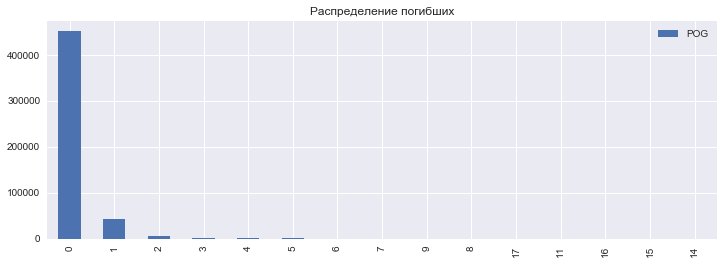

In [15]:
data.POG.value_counts().plot(kind='bar', figsize=(12,4))
plt.legend()
plt.title('Распределение погибших');

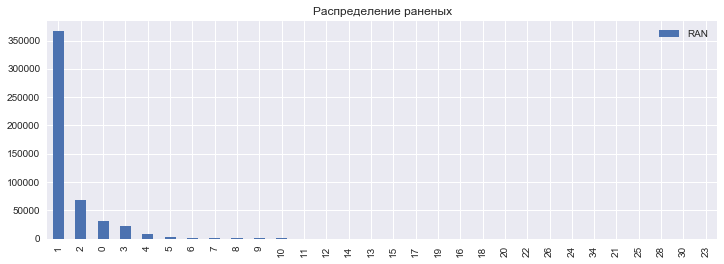

In [16]:
data.RAN.value_counts().plot(kind='bar', figsize=(12,4))
plt.legend()
plt.title('Распределение раненых');

In [17]:
#  строк, где никто не погиб и не ранен, нет
len(data[(data.RAN == 0) & (data.POG == 0)])

0

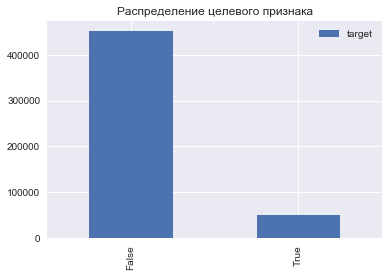

In [18]:
# создаем целевую переменную
data['target'] = data['POG'] > 0

data.target.value_counts().plot(kind='bar', label='target')
plt.legend()
plt.title('Распределение целевого признака');

In [19]:
data.target.value_counts()

False    451330
True      50037
Name: target, dtype: int64

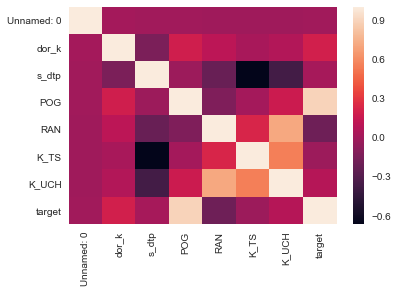

In [20]:
# большинство признаков - категориальные, поэтому корреляции трудно оценить на этапе первичного анализа
sns.heatmap(data.corr())

Естественна корелляция между таргетом и числом погибших, легкая корреляция между погибшими и ранеными, сильная корреляция между количеством машин/участников/раненых, что понятно.

# 3. Первичный визуальный анализ данных

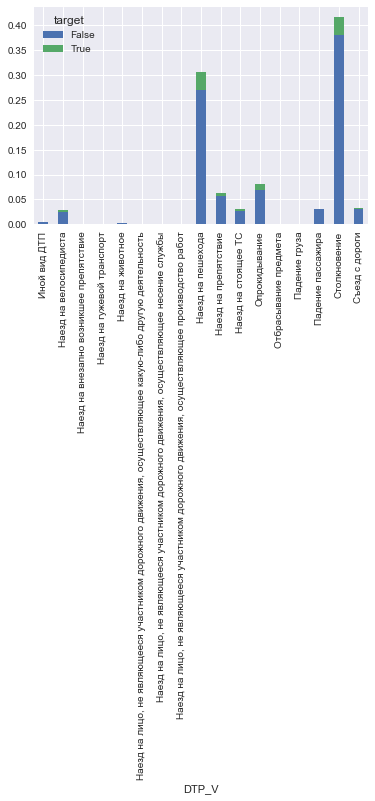

In [21]:
ct = pd.crosstab(data['DTP_V'], data['target'], normalize=True)

ct.plot.bar(stacked=True)
plt.legend(title='target')

plt.show()

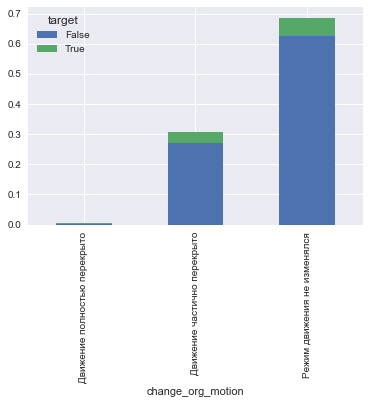

In [22]:
ct = pd.crosstab(data['change_org_motion'], data['target'], normalize=True)

ct.plot.bar(stacked=True)
plt.legend(title='target')

plt.show()

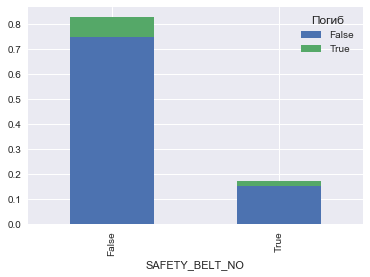

In [23]:
data['SAFETY_BELT_NO'] = data.SAFETY_BELT.apply(lambda x: 'Нет' in x)


ct = pd.crosstab(data['SAFETY_BELT_NO'], data['target'], normalize=True)
ct.plot.bar(stacked=True)
plt.legend(title='Погиб')

plt.show()

Странно, но ремень слабо влияет на смертность. Возможно дело в некоректных данных, сложно представить как сотрудники после аварии определяют был ремень или нет. Можно было бы предположить, что только в случае, если человек не выбрался из автомобиля, погиб вероятнее всего. То есть была бы утечка данных таргета. Но нет, распределение не подтверждает, что признак ремень == "нет" как-то коррелирует с таргетом. Вероятно, заполняют просто так.

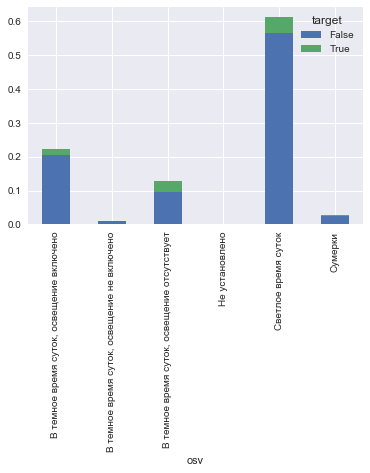

In [24]:
ct = pd.crosstab(data['osv'], data['target'], normalize=True)

ct.plot.bar(stacked=True)
plt.legend(title='target')

plt.show()

Посмотрим на аварийность по регионам с учетом численности населения этих регионов

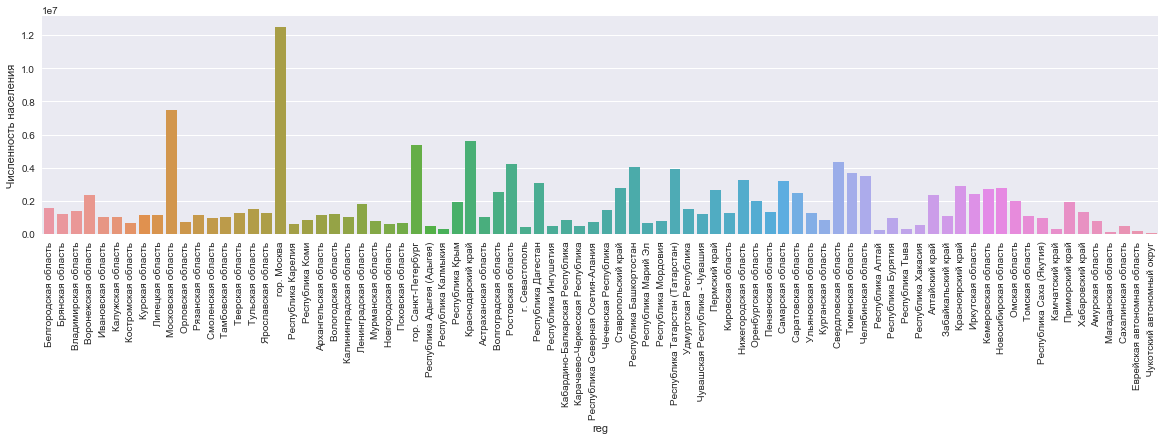

In [82]:
# численность населения рф по регионам
# http://www.gks.ru/free_doc/new_site/population/demo/Popul2018.xls

regions = pd.read_excel('Popul2018.xls', names=['reg', 'value'], header=5, usecols=[0,1])
regions['reg'] = regions['reg'].apply(lambda x: x.strip())
regions['reg'] = regions['reg']\
    .replace('г. Москва', 'гор. Москва')\
    .replace('г.Санкт-Петербург', 'гор. Санкт-Петербург')\
    .replace('Республика Татарстан', 'Республика Татарстан (Татарстан)')\
    .replace('Республика Адыгея', 'Республика Адыгея (Адыгея)')\
    .replace('Чувашская Республика', 'Чувашская Республика - Чувашия')\

okrug_filter = regions['reg'].str.contains('округ') & ~regions['reg'].str.contains('Чукотский автономный округ')
regions = regions[~okrug_filter]

d = {elem[0]: elem[1] for elem in regions.values}


plt.subplots(figsize=(20,4))
ax = sns.barplot(x=regions.reg, y=regions.value)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Численность населения")
plt.show()

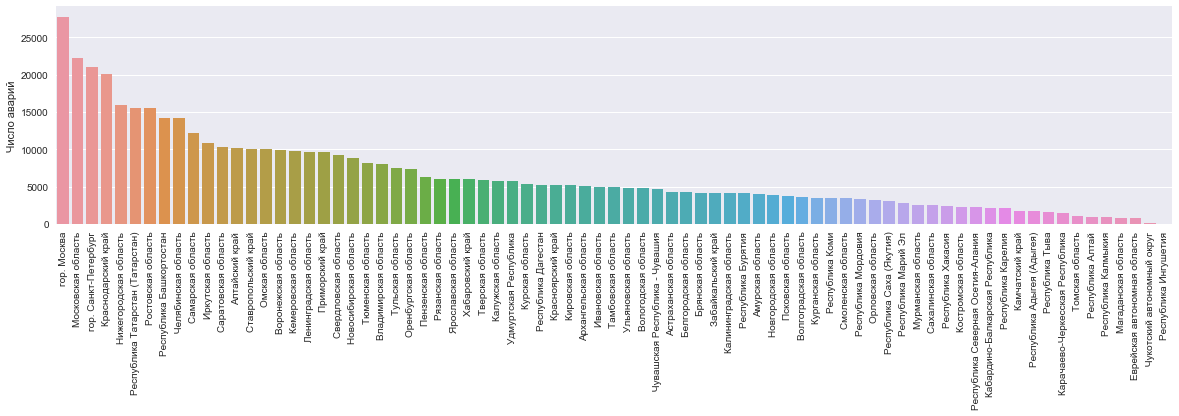

In [83]:
data['region_only'] = data['reg_name'].apply(lambda x: x.split(',')[0])  # выделяем регион ДТП в отдельную колонку

by_region = data['region_only'].value_counts()
by_region_df = pd.DataFrame(by_region)
by_region_df['people'] = list(map(lambda x: d.get(x), by_region.index.values))

by_region_df['percent'] = by_region_df['region_only'] / by_region_df['people']


plt.subplots(figsize=(20,4))
ax = sns.barplot(x=by_region_df.index, y=by_region_df.region_only)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Число аварий")
plt.show()

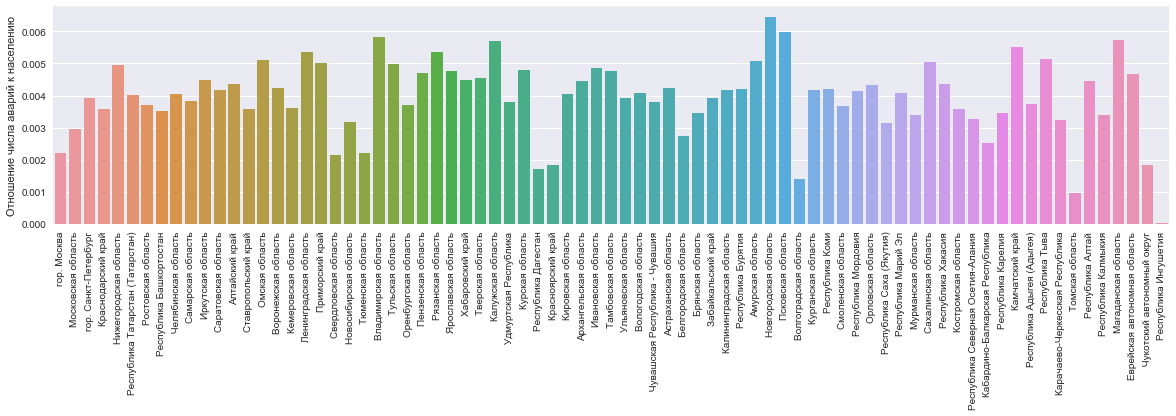

In [84]:
plt.subplots(figsize=(20,4))
ax = sns.barplot(x=by_region_df.index, y=by_region_df.percent)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Отношение числа аварий к населению")
plt.show()

Видно, что в процент аварий к численности населения сильно отличается по регионам, есть более опасные и более безопасные. Возможны пропуски в данных, какой-то из регионов выпал из скрипта (см. Ингушетия), собирающего информацию (особенности кодирования, ошибки в ОКВЕД, предмет отдельного изучения)

Посмотрим на алкоголь

In [40]:
data['alco_sum'] = data.ALCO.apply(lambda x: sum(map(int, x)))

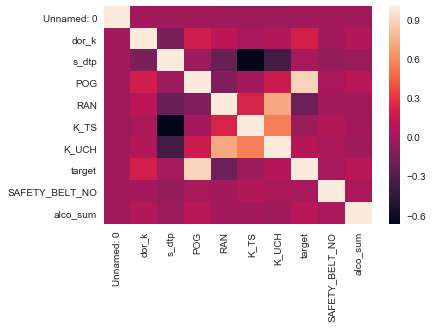

In [42]:
sns.heatmap(data.corr())

Есть слабая корреляция алкоголя, погибших и класса дороги

# 4. Инсайты, найденные зависимости


Очевидно, сильное значение имеет алкоголь, регион, вид дтп, освещение, тип машины, тип нарушения, в общем почти всё важно. Попробуем загнать все характеристики в модель и посмотрим важность признаков.

# 5. Выбор метрики
Мы поставили задачу бинарной классификации. Наша задача - получить веса, максимально отделяющие классы друг от друга. Классы не сбалансированы. Есть два основных кандидата на роль метрики при таких обстоятельствах, ROC-AUC и LogLoss. В данном случае нам скорее подходит ROC-AUC, как метрика, максимально отделяющая классы, и потому что нам не так важно насколько именно мы правы или нет (для этого подходит LogLoss). [Чуть более подробные объяснения](https://stats.stackexchange.com/questions/322408/logloss-vs-gini-auc)

# 6. Выбор модели

Задача бинарной классификации, число признаков, с учетом OneHotEncoding, не превышает 10000 (иначе бы мы были ограничены линейными моделями), поэтому мы можем попробовать несколько алгоритмов и посмотреть, какой из них справится лучше, и уже его настраивать. Мы хотим получить интерпретируемые веса, поэтому не рассматриваем нейронные сети. Вероятно, хорошо подойдут следующие модели:

- LogisticRegression
- SVC (квадратичная сложность от числа примеров, слишком долго получится на полном датасете, проверим на части)
- GradientBoosting
- RandomForest
- SGDClassifier

Конкретные результаты посмотрим после предобработки данных

# 7. Предобработка данных


Мы выбираем для обучения только категориальные признаки, числовых в нашем датасете нет, соответственно нет выбросов, пропуски мы уже заполнили. Раскладываем списки с помощью MultiLabelBinarizer, а простые категории - с помощью LabelBinarizer. Бинарные признаки берем как есть.
Отбор признаков осуществим в п.9 плана.

In [85]:
def prepare_x(multi_list, single_list, binary_list, data):
    arr_multicategorial = []
    for col in multi_list:
        mlb = MultiLabelBinarizer()
        transformed = mlb.fit_transform(data[col])
        arr_multicategorial.append(pd.DataFrame(transformed, 
                                                columns=col + '_' + mlb.classes_.astype('object'),
                                                ).to_sparse())

    arr_categorial = []
    for col in single_list:
        lb = LabelBinarizer()
        transformed = lb.fit_transform(data[col])
        arr_categorial.append(pd.DataFrame(transformed,
                                           columns=col + '_' + lb.classes_.astype('str').astype('object'),
                                           ).to_sparse())


    binary_data = data[binary_list]


    concated_df = pd.concat(arr_multicategorial+arr_categorial + [binary_data], axis=1).to_sparse()
    
    return concated_df

In [47]:
m = ['t_ts', 'color', 'SAFETY_BELT', 'all_NPDD', 'POL', 't_n', 'OBJ_DTP', 'factor', 'ndu', 's_pog', 'sdor']
s = ['DTP_V', 'dor_k', 'dor_z', 'k_ul', 'osv']
b = []



X = prepare_x(m, s, b, data)
y = data['target']  

columns_names = X.columns

In [48]:
from sklearn.model_selection import train_test_split, cross_validate

# оставляем 10% данных на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE, shuffle=True)

In [23]:

score_lr = cross_validate(LogisticRegression(), X_train, y_train, scoring='roc_auc')

In [24]:
score_gbc = cross_validate(GradientBoostingClassifier(), X_train, y_train, scoring='roc_auc')

In [43]:
score_rf = cross_validate(RandomForestClassifier(), X_train, y_train, scoring='roc_auc')

In [29]:
score_sgd = cross_validate(SGDClassifier(), X_train, y_train, scoring='roc_auc')

In [39]:
score_svc_linear = cross_validate(SVC(kernel='linear', probability=True), X_train[:10000], y_train[:10000], scoring='roc_auc')

In [41]:
score_svc_rbf = cross_validate(SVC(probability=True), X_train[:10000], y_train[:10000], scoring='roc_auc')

In [44]:
score_lr, score_gbc, score_rf, score_sgd, score_svc_linear, score_svc_rbf

({'fit_time': array([143.93667555, 141.16015935, 138.21345663]),
  'score_time': array([16.8259511 , 15.31471419, 14.85248756]),
  'test_score': array([0.80273319, 0.80029986, 0.7983378 ]),
  'train_score': array([0.80272497, 0.80354234, 0.80415601])},
 {'fit_time': array([468.94029975, 475.13572717, 467.66327477]),
  'score_time': array([15.5774138 , 15.47715068, 15.91130328]),
  'test_score': array([0.79984123, 0.79672252, 0.79499331]),
  'train_score': array([0.79923029, 0.79994053, 0.80033531])},
 {'fit_time': array([139.82270789, 141.69571733, 140.69706106]),
  'score_time': array([15.75691891, 15.87821364, 15.83810854]),
  'test_score': array([0.71873369, 0.71485467, 0.71616459]),
  'train_score': array([0.99911768, 0.99906525, 0.99905563])},
 {'fit_time': array([127.22022963, 126.88935137, 126.34490418]),
  'score_time': array([15.39793658, 15.43503618, 14.99386525]),
  'test_score': array([0.70969448, 0.73348516, 0.7507287 ]),
  'train_score': array([0.7119345 , 0.73746648, 0.7

Получается, что несколько алгоритмов показывают хорошие результаты. Можно выделить логистическую регрессию, градиентный бустинг(немного долго) и случайный лес(сильно переобучается, но если над этим посидеть результаты можно улучшить). SVC тоже может дойти до хороших результатов, но квадратичная сложность делает его малоприменимым при нашем датасете

Возьмем как основной алгоритм логистическую регрессию.

# 8. Кросс-валидация и настройка гиперпараметров модели

Данных у нас много, не временные ряды, датасет уже произвольно отсортирован при train-test сплите. Поэтому обычный K-Fold.

In [45]:
kf = KFold(n_splits=3, random_state=RANDOM_STATE)  # по умолчанию в большинстве методов sklearn

In [49]:
# обучим модель и посмотрим на веса признаков
clf = LogisticRegression()

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
eli5.show_weights(clf, feature_names=columns_names.values, top=50)

Weight?,Feature
+1.652,all_NPDD_Оставление движущегося транспортного средства (выход или выпрыгивание на ходу и т.д.)
+1.570,t_ts_Автоцементовозы
+1.438,"t_n_Неисправность рулевого управления | На одну ось ТС установлены шины различных размеров, конструкций (радиальной, диагональной, камерной, бескамерной), моделей, с различными рисунками протектора. На ТС одновременно установлены ошипованные и неошипованные шины"
+1.436,t_ts_Подвижной состав ж/д
+1.372,"DTP_V_Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность"
+1.279,t_ts_Бульдозеры
+1.273,t_n_Коэффициент светопропускания стекол менее нормативного | Отсутствуют предусмотренные конструкцией транспортного средства ремни безопасности и(или) подголовники сидений
+1.271,t_ts_Автолесовозы
+1.203,t_ts_Иные дорожно-строительные и дорожно-эксплуатационные машины и механизмы
+1.195,t_n_Шины не соответствуют модели ТС | Коэффициент светопропускания стекол менее нормативного


Признак SAFETY_BELT при любых значениях, как видно, является утечкой в целевую переменную (и "Да", и "Нет" имеют высокие положительные веса), потому что его появление может быть объяснимо только в случае, если человек не смог выйти сам из автомобиля, то есть погиб, вылетел из машины или был без сознания.
Его, очевидно, лучше исключить.

Видно, что мы забыли разложить признак t_n "технические неисправности" на составляющие, сделаем это в п.9


У логистической регрессии мы можем перебрать следующие параметры в случае бинарной классификации:

- penalty : str, ‘l1’ or ‘l2’, default: ‘l2’
- C : Сила регуляризации, меньше значения - сильнее регуляризация
- class_weight : dict or ‘balanced’, default: None

Используем поиск по гриду на части выборки для скорости, С посмотрим приблизительно, более точно в п.10.

In [ ]:
param_grid = dict(penalty=['l1', 'l2'], C=[0.1, 1], class_weight=['balanced', None])
gs = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1), param_grid=param_grid, scoring='roc_auc', cv=kf, verbose=10)
gs.fit(X_train[:50000], y_train[:50000])

In [79]:
gs.cv_results_

{'mean_fit_time': array([17.97545449, 15.43904583, 15.62453842, 15.10849873, 32.5869689 ,
        15.90762448, 22.44132757, 15.512743  ]),
 'mean_score_time': array([1.90105859, 1.8950394 , 1.70424255, 2.13502471, 1.74697892,
        1.89136394, 1.81315613, 1.77605613]),
 'mean_test_score': array([0.79422175, 0.79484056, 0.78951416, 0.79386891, 0.79322618,
        0.79324589, 0.79436227, 0.79442025]),
 'mean_train_score': array([0.80347276, 0.80834222, 0.79496432, 0.80393264, 0.81275371,
        0.81305838, 0.80887897, 0.81047769]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', 'balanced', None, None, 'balanced',
                    'balanced', None, None],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'pa

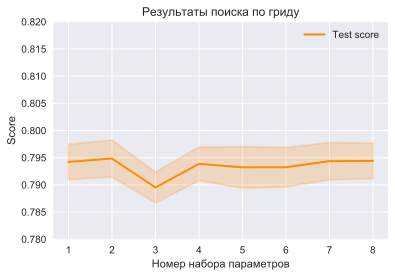

In [85]:
plt.title("Результаты поиска по гриду")
plt.xlabel("Номер набора параметров")
plt.ylabel("Score")
plt.ylim(0.78, 0.82)
lw = 2
plt.plot(range(1, 9), gs.cv_results_['mean_test_score'], label="Test score",
             color="darkorange", lw=lw)
plt.fill_between(range(1, 9), gs.cv_results_['mean_test_score'] - gs.cv_results_['std_test_score'],
                 gs.cv_results_['mean_test_score'] + gs.cv_results_['std_test_score'], alpha=0.2,
                 color="darkorange", lw=lw)
plt.legend(loc="best")
plt.show()

Видно, что гиперпараметры в нашем случае (кроме C, который стоит перебрать) не оказывают существенного влияния, все в пределах стандартного отклонения, но возьмем лучший, и в п.10 настроим C.

In [86]:
gs.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

# 9. Создание новых признаков и описание этого процесса 

In [51]:
# добавляем временные признаки, дорожные условия, погода, количество машин на дорогах, освещение. Важные признаки
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['Time'], dayfirst=True)

data["Year"] = data["datetime"].dt.year
data["Month"] = data["datetime"].dt.month
data['Weekday'] = data['datetime'].dt.weekday
data["Hour"] = data["datetime"].dt.hour
data["Month_Day"] = data['datetime'].dt.day
data["Year_Day"] = data['datetime'].dt.dayofyear

# Year_Day видимо будет переобучением, проверим

In [52]:
# добавляем нарушения пешехода, упустили в начале
def get_sublists_npdd_uch(x):
    res = list()
    for uch in json.loads(x):
        for npdd in uch['NPDD']:
            res.append(npdd)
    return res

data['NPDD_UCH'] = data['uchInfo'].apply(get_sublists_npdd_uch)

In [53]:
# создаем категориальные признаки алкоголя, очевидно одна из основных 
data['MAX_ALCO'] = data['ALCO'].apply(lambda x: max(map(int, x)) if x else 0).astype(int)
data['HIGH_ALCO'] = data['MAX_ALCO'] > 20
data['MEDIUM_ALCO'] = (data['MAX_ALCO'] > 10) &  (data['MAX_ALCO'] < 20)

In [54]:
# разворачиваем признак t_n в список, например "Неисправность рабочей тормозной системы | Не устанавливались" в две категории
def convert_t_n(x):
    res = list()
    for e in x:
        res += e.split('|')
    return res
        
data['t_n'] = data['t_n'].apply(convert_t_n)


In [55]:
m = ['t_ts', 'color', 'SAFETY_BELT', 'all_NPDD', 'POL', 't_n', 'OBJ_DTP', 'factor', 'ndu', 's_pog', 'sdor', 'NPDD_UCH']
s = ['DTP_V', 'dor_k', 'dor_z', 'k_ul', 'osv', 'region_only', 's_pch', 'Month', 'Weekday', 'Hour']
b = ['MEDIUM_ALCO', 'HIGH_ALCO']

X = prepare_x(m, s, b, data)
y = data['target']
column_names = X.columns

In [56]:
# оставляем 10% данных на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE, shuffle=True)

Оценим результаты с признаком ремня безопасности и без них

In [59]:
clf = LogisticRegression(C=0.1,  class_weight='balanced', random_state=RANDOM_STATE)

clf.fit(X_train, y_train)
score_with_belt = roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1])

In [60]:
def df_without_belt(df):
    return df.loc[:, ~df.columns.str.startswith('SAFETY_BELT')]

clf = LogisticRegression(C=0.1,  class_weight='balanced', random_state=RANDOM_STATE)
clf.fit(df_without_belt(X_train), y_train)
score_without_belt = roc_auc_score(y_test,clf.predict_proba(df_without_belt(X_test))[:, 1])

In [61]:
score_with_belt, score_without_belt

(0.820286180510051, 0.8183613061055898)

Без ремня стало хуже, но, опять таки, по моим ощущениям - это утечка в таргет, невозможно сотруднику в простом ДТП понять, был ремень или нет. Сомнительный признак.
Переделываем X без него

In [62]:
m = ['t_ts', 'color', 'all_NPDD', 'POL', 't_n', 'OBJ_DTP', 'factor', 'ndu', 's_pog', 'sdor', 'NPDD_UCH']
s = ['DTP_V', 'dor_k', 'dor_z', 'k_ul', 'osv', 'region_only', 's_pch', 'Month', 'Weekday', 'Hour']
b = ['MEDIUM_ALCO', 'HIGH_ALCO']

X = prepare_x(m, s, b, data)
y = data['target']
column_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE, shuffle=True)

Выбираем 50% самых значимых признаков        

In [63]:
from sklearn.feature_selection import SelectPercentile

sp = SelectPercentile(percentile=50) # выбираем 50% самых значимых признаков

X_selected = sp.fit_transform(X_train, y_train)


In [64]:
X_test_selected = sp.transform(X_test)

In [65]:
columns = X_test.columns[sp.get_support()]


# 10. Построение кривых валидации и обучения

In [66]:
def show_curve(train_scores, valid_scores, param_range, title, xlabel, ymin=0.78, ymax=0.82):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.ylim(ymin, ymax)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [ ]:
param_range = np.logspace(-4, 2, 20)
train_scores, valid_scores = validation_curve(LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE), X_selected, y_train, "C", param_range, n_jobs=-1, cv=kf, scoring='roc_auc', verbose=10)

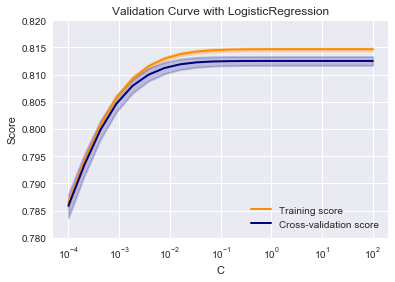

In [ ]:
show_curve(train_scores, valid_scores, param_range, "Validation Curve with LogisticRegression", "C")

In [ ]:
train_sizes, learning_train_scores, learning_valid_scores = learning_curve(LogisticRegression(C=0.1,  class_weight='balanced', random_state=RANDOM_STATE), X_selected, y_train, train_sizes=np.logspace(-2, 0, 10), cv=kf, scoring='roc_auc', verbose=10)

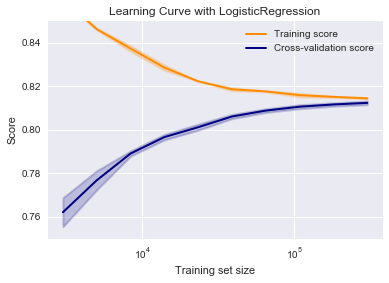

In [76]:
show_curve(learning_train_scores, learning_valid_scores, train_sizes, "Learning Curve with LogisticRegression", "Training set size", 0.75, 0.85)

In [77]:
train_sizes

array([  3008,   5017,   8370,  13962,  23291,  38852,  64809, 108109,
       180336, 300820])

По кривой валидации видно, что лучшее значение параметра C лежит около 0.1. При дальнейшем увеличении результаты не растут. Кривые обучения близко, ошибка средняя, обусловленная, по всей видимости, случайной природой целевой переменной.

Кривая обучения показывает, что результаты на тренировочной и валидационной части сходятся, на полной выборке 500 тысяч строк сойдутся окончательно (На картинке - 2/3 выборки, с учетом KFold3)

# 11. Прогноз для тестовой выборки


In [78]:
# результаты на тестовой выборке
clf = LogisticRegression(C=0.1,  class_weight='balanced', random_state=RANDOM_STATE)

clf.fit(X_selected, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [79]:
final_score = roc_auc_score(y_test,clf.predict_proba(X_test_selected)[:, 1])
final_score

0.8152220188448539

Результаты на тестовой выборке сравнимы с результатами на кросс-валидации, даже чуть лучше за счет использования всей тренировочной части (на кривых обучения и валидации использовалось 66%)

Проведем финальное обучение на полном датасете и посмотрим результаты.



In [80]:
X_selected_all = sp.fit_transform(X, y)

clf.fit(X_selected_all, y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [81]:
columns_names = X.columns[sp.get_support()]  # получаем имена оставленных колонок

eli5.explain_weights(clf, feature_names=columns_names.values, top=200)

Weight?,Feature
+1.560,"DTP_V_Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ"
+1.529,"DTP_V_Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность"
+1.282,HIGH_ALCO
+1.125,t_ts_Оснащённые специализированным оборудованием автотранспортные средства для коммунального хозяйства и содержания дорог
+1.078,DTP_V_Наезд на пешехода
+1.069,t_ts_Подвижной состав ж/д
+1.061,t_ts_Фронтальные погрузчики
+1.038,t_ts_Иные дорожно-строительные и дорожно-эксплуатационные машины и механизмы
+1.012,t_ts_Автолесовозы
+1.006,DTP_V_Наезд на велосипедиста


# 12. Выводы

Мы получили интересные результаты, которые могут помочь оценить риск в той или иной ситуации на дороге, выделили признаки на которые стоит обратить внимание при вождении и техническом обслуживании автомобиля.

Видно, что выезд на полосу встречного движения является самым страшным с точки зрения последствий нарушением ПДД, пить надо меньше, а пребывание в Краснодарском крае или Воронежской области равновелико по опасности с отсутсвием освещения! Так же стоит проявлять особую бдительность при встрече с крупными транспортными средствами. И аккуратнее ночью!

Вдоль дороги лучше вообще не работать или пользоваться всеми возможными бликерами.

Неисправность тормозной системы, тонкие шины, разные шины на разных осях - причина гибели!

Ну а самое безопасное нарушение - правила пользования общественным транспортом. Ну и на автостоянке сложно погибнуть.

Также, в результате работы мы получили интересный качественный датасет, с которым можно работать дальше. К примеру, можно посмотреть зависимость травматичности от марки или модели машины, в случае конкретных участников (мы рассматривалии аварию в целом). Можно посмотреть геоданные, координаты, названия дорог, населенных пунктов для определения наиболее опасных участков.


Буду рад замечаниям и предложениям


[Павел Куликов](http://kulikovpavel.ru)

kulikovpavel@gmail.com

+7 903 118 37 41